In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

from _cd_diagram import draw_cd_diagram

# Getting some free samples
results_df.sample(3)

# Don't change any code below, it may break (probably will) --------------------



['../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown1e-6.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp.py'] ['Top Down 1e-1', 'Bottom Up (only last)', 'Top Down (only last)', 'Bottom Up 1e-6', 'Bottom Up 1e-2', 'Bottom Up 1e-10', 'Top Down 1e-0', 'Bottom Up 1e-0', 'Top Down 1e-4', 'Top Down 1e-6', 'Without simplify', 'Bottom Up 1e-4', 'Top Down', 'Top Down 1e-10', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up']
(539, 14)
['Without simplify' 'Top Down' 'Bottom U

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth
326,Top Down,Energy Heating,0,32400,1645.737579,01-30-2024 00:25:54,0.895484,0.900189,9.983583,10.471856,"exp(sqrtabs(add(sqrtabs(add(subtract(-32.41949476504612, multiply(-41.022104363911005, x_6)), sqrt(multiply(x_2, x_4)))), x_4)))",15,1824,7
115,Without simplify,Concrete,0,4866,1484.722639,01-29-2024 23:09:14,0.738556,0.723270,59.900041,58.092994,"add(add(multiply(-1.0274247413673039, sqrtabs(cdiv(subtract(tan(-73.92576271142056), x_7), multiply(x_4, minimum(x_7, x_1))))), square(cdiv(add(maximum(x_7, x_0), add(x_1, x_0)), subtract(x_4, subtract(-164.81111238171218, x_4))))), add(expm1(expm1(arctan(multiply(37.41069410159305, cdiv(x_7, x_3))))), x_4))",39,2988,7
336,Bottom Up,Energy Heating,0,26311,2500.799057,01-29-2024 23:48:37,0.988224,0.989927,1.154419,1.038824,"add(add(square(multiply(multiply(log1p(x_4), add(sqrtabs(x_6), 2.3800996929189333)), 0.9576726084543672)), subtract(arctan(add(-515.1354264678781, x_1)), cdiv(8.041808357582592, square(cos(tan(x_3)))))), maximum(multiply(tan(exp(sin(expm1(x_2)))), x_4), expm1(arcsin(square(cos(tan(x_3)))))))",37,17234,7


criteria         Harmonic Mean size mean score                      \
                          mean              lb      mean        ub   
model                                                                
Top Down              2.079868        1.915664  2.016188  2.116711   
Bottom Up             2.070950        1.836276  1.983333  2.130391   
Without simplify      1.822458        1.864417  1.994444  2.124472   

criteria         test_mse mean score                      
                                  lb      mean        ub  
model                                                     
Top Down                    2.023712  2.147701  2.271690  
Bottom Up                   2.101335  2.166667  2.231999  
Without simplify            1.553056  1.677778  1.802500

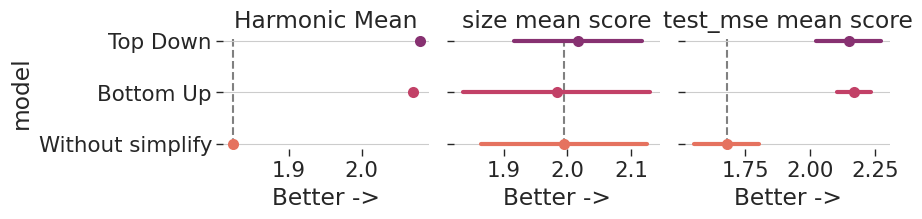

criteria         Harmonic Mean complexity mean score                      \
                          mean                    lb      mean        ub   
model                                                                      
Top Down              2.030077              2.034932  2.183525  2.332118   
Bottom Up             2.027005              2.015593  2.161111  2.306629   
Without simplify      1.891924              1.544993  1.650000  1.755007   

criteria         depth mean score                     size mean score  \
                               lb      mean        ub              lb   
model                                                                   
Top Down                 1.991782  2.005556  2.019329        1.915664   
Bottom Up                1.976896  2.002778  2.028660        1.836276   
Without simplify         1.968386  1.986111  2.003837        1.864417   

criteria                             test_mse mean score                      \
                      mean        ub                  lb      mean        ub   
model                                                                          
Top Down          2.016188  2.116711            2.023712  2.147701  2.271690   
Bottom Up         1.983333  2.130391            2.101335  2.166667  2.231999   
Without simplify  1.994444  2.124472            1.553056  1.677778  1.802500   

criteria         test_r2 mean score                      
                                 lb      mean        ub  
model                                                    
Top Down                   1.699586  1.835632  1.971678  
Bottom Up                  1.771776  1.855556  1.939335  
Without simplify           2.180763  2.294444  2.408126

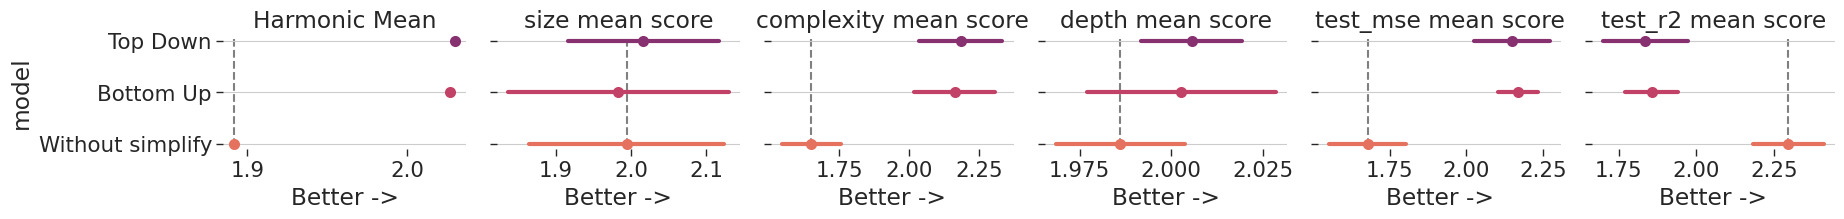

criteria         Harmonic Mean complexity mean score                      \
                          mean                    lb      mean        ub   
model                                                                      
Top Down              2.030077              2.034932  2.183525  2.332118   
Bottom Up             2.027005              2.015593  2.161111  2.306629   
Without simplify      1.891924              1.544993  1.650000  1.755007   

criteria         depth mean score                     size mean score  \
                               lb      mean        ub              lb   
model                                                                   
Top Down                 1.991782  2.005556  2.019329        1.915664   
Bottom Up                1.976896  2.002778  2.028660        1.836276   
Without simplify         1.968386  1.986111  2.003837        1.864417   

criteria                             test_mse mean score                      \
                      mean        ub                  lb      mean        ub   
model                                                                          
Top Down          2.016188  2.116711            2.023712  2.147701  2.271690   
Bottom Up         1.983333  2.130391            2.101335  2.166667  2.231999   
Without simplify  1.994444  2.124472            1.553056  1.677778  1.802500   

criteria         test_r2 mean score                      
                                 lb      mean        ub  
model                                                    
Top Down                   1.699586  1.835632  1.971678  
Bottom Up                  1.771776  1.855556  1.939335  
Without simplify           2.180763  2.294444  2.408126

In [2]:
def plot_rankings(columns, results_df, path):
    ranks_data = []
    for col in columns:
        ranks_df = results_df.pivot( # Smaller is better for all columns here
            index=['dataset', 'RunID', 'random_state'], columns='model', values=col
        ).rank(ascending=False, axis=1).groupby('dataset').mean()#.rank(ascending=False, axis=1)
        
        for model in results_df['model'].unique():
            df_model = ranks_df[ model ]
            values = df_model.values

            # Estimating lower and upper confidence bounds
            lb, ub = stats.norm.interval(confidence=0.95, loc=np.mean(values),
                                        scale=stats.sem(values))
            lb = np.nan_to_num(lb, 0.0)
            ub = np.nan_to_num(ub, 0.0)

            ranks_data.append( (model, f'{col} mean score', df_model.mean(), lb, ub) )

    # Creating the dataframe
    ranks_data_df = pd.DataFrame(data=ranks_data,
                                columns=['model', 'criteria', 'mean', 'lb', 'ub'])

    ranks_data_df = ranks_data_df.pivot(columns='criteria', index='model')

    # will calculate the harmonic mean and plot the columns based on mean rankings
    ranks_data_df[('mean', 'Harmonic Mean')] = (
        ranks_data_df[[('mean', f'{col} mean score') for col in columns]]
    )['mean'].apply(stats.hmean, axis=1)

    ranks_data_df = ranks_data_df.sort_values(by=('mean', 'Harmonic Mean'), ascending=False)
    ranks_data_df = ranks_data_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    display(ranks_data_df)
    #print(ranks_data_df.to_latex())

    # Use semantically meaningful titles for the columns
    titles = ['Harmonic Mean']+[f'{col} mean score' for col in columns]

    # Now making the plot
    g = sns.PairGrid(ranks_data_df.reorder_levels([1, 0], axis=1)['mean'].reset_index(),
                    x_vars=titles, y_vars=['model'], height=2.5, aspect=1.25)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=8, orient="h", jitter=False,
        palette="flare_r", linewidth=0, edgecolor="w")

    # setting the reference as the Baseline 
    unif = ((ranks_data_df[ ranks_data_df.index=='Without simplify'])['Harmonic Mean'])['mean'].values[0]
    g.axes.flat[0].axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

    g.axes.flat[0].set(title='Harmonic Mean')
    g.axes.flat[0].set_xlabel('Better ->')
    #g.axes.flat[0].set_xlim( (-1, len(ranks_data_df.index)+1) )

    # Make the grid horizontal instead of vertical
    g.axes.flat[0].xaxis.grid(False)
    g.axes.flat[0].yaxis.grid(True)

    for ax, title in zip(g.axes.flat[1:], titles[1:]):
        color = iter(sns.color_palette("flare_r", ranks_data_df.shape[0]))
        for tick, text in zip(g.axes.flat[0].get_yticks(), g.axes.flat[0].get_yticklabels()):
            c=next(color)
            sample_name = text.get_text()  # "X" or "Y"
            single_df = ranks_data_df[ ranks_data_df.index==sample_name ]
            
            lb, ub, mean_val = (single_df[title])[ ['lb', 'ub', 'mean'] ].values[0]
            rank_val = ranks_data_df.reset_index()[(ranks_data_df.reset_index()['model']==sample_name)].index

            # plot horizontal lines across the column, centered on the tCIk
            ax.plot([lb, ub], [rank_val, rank_val], lw=3, color=c)

        # Draw a reference line on baseline
        unif = (ranks_data_df[ ranks_data_df.index=='Without simplify'])[(title, 'mean')].values[0]
        ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

        # Set a different title for each axes
        ax.set(title=title)
        ax.set_xlabel('Better ->')
        #ax.set_xlim( (-1, len(ranks_data_df.index)+1) )

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.savefig(f'{path}.pdf')
    plt.savefig(f'{path}.png', dpi=600)

    plt.show()

    return ranks_data_df

plot_rankings(['size', 'test_mse'], results_df, "../paper/figs/size_mse")
plot_rankings(['size', 'complexity', 'depth', 'test_mse', 'test_r2'], results_df, "../paper/figs/size_mse_compexity_depth")
